In [1]:
%load_ext autoreload
%autoreload 2

from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo"]

transform_list = [
    SelectQM9TargetProperties(properties=properties),
    SelectQM9NodeFeatures(features=["atom_type"]),
]
if not include_hydrogen:
    transform_list.append(DropQM9Hydrogen())

max_num_nodes = 29 if include_hydrogen else 9
transform_list += [
    AddAdjacencyMatrix(max_num_nodes=max_num_nodes),
    AddNodeAttributeMatrix(max_num_nodes=max_num_nodes),
    AddEdgeAttributeMatrix(max_num_nodes=max_num_nodes),
]

pre_transform = T.Compose(transform_list)
transform = T.Compose([
    #RandomPermutation(max_num_nodes=max_num_nodes),
    T.ToDevice(device=device)
])

dataset = QM9(root="./data", pre_transform=pre_transform, pre_filter=qm9_pre_filter, transform=transform)

train_dataset, val_dataset, test_dataset = create_qm9_data_split(dataset=dataset)

In [3]:
batch_size = 4096
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "full": DataLoader(dataset, batch_size=batch_size, shuffle=False)
}

In [9]:
# load model
checkpoint_path = "./checkpoints/graph_vae_20240303_204747.pt"
graph_vae_model = GraphVAE.from_pretrained(checkpoint_path).to(device=device)

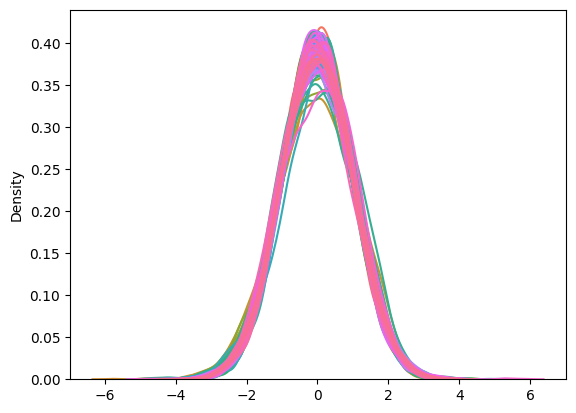

In [10]:
graph_vae_model.eval()

val_loader = dataloaders["val"]
batch = next(iter(val_loader))
z = graph_vae_model.encode(batch).detach().cpu()

latent_dim = graph_vae_model.latent_dim
for dim in range(z.shape[1]):
    sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

# plt.title(f'KDE of each latent dimension (n={latent_dim})')
plt.show()  

In [11]:
import pandas as pd

graph_vae_model.eval()

loader = dataloaders["full"]

z_list = []
props_list = []
for batch in tqdm(loader):
    z = graph_vae_model.encode(batch).detach().cpu()
    z_list.append(z)
    props_list.append(batch.y)

z = torch.concat(z_list)
props = torch.concat(props_list)
prop_df = pd.DataFrame(props.cpu(), columns=properties).reset_index()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


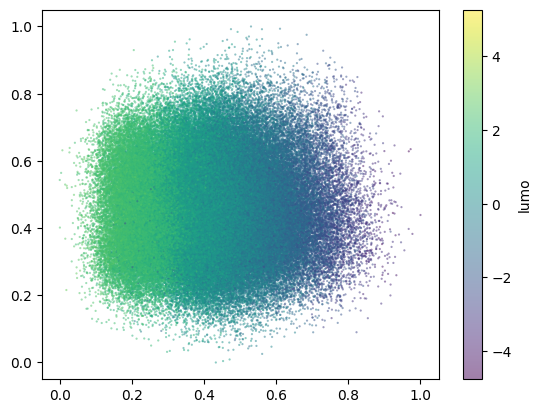

In [12]:
prop_opt = "lumo"

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.colorbar(scatter, label=prop_opt)
plt.show()

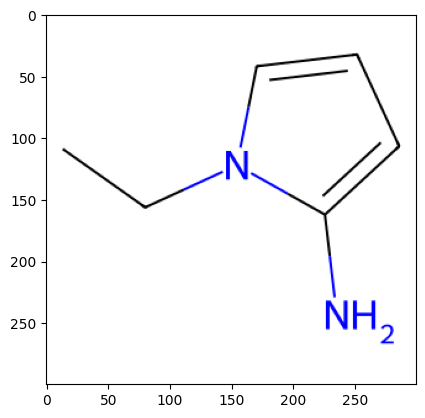

In [134]:
# TODO: get random val set molecule and plot
src_mol_graph = val_dataset[256]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.show()

In [142]:
# TODO: optimize homo - lumo on z of the encoded mol with gradient descent
z = graph_vae_model.encode(src_mol_graph)
y = graph_vae_model.predict_properties(z)
y

tensor([[-6.3611,  2.3463]], device='cuda:0', grad_fn=<AddmmBackward0>)

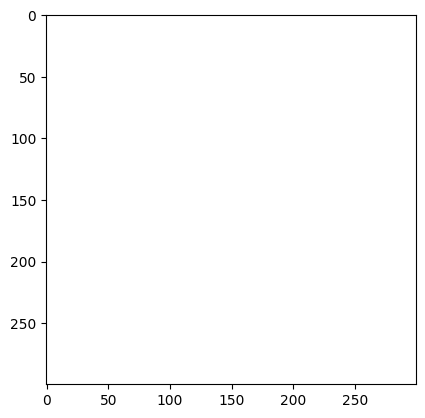

In [143]:
# TODO: decode mol and display
dst_mol_graph = graph_vae_model.output_to_graph(graph_vae_model.decode(z), stochastic=True)
dst_mol = graph_to_mol(dst_mol_graph, includes_h=False, validate=False)
dst_mol_img = mol_to_image_tensor(dst_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(dst_mol_img[0])
plt.show()

In [ ]:
# TODO: optimize z wrt target (homo - lumo)